In [2]:
import torch
import numpy as np
import torch.nn as nn
import copy
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import json
from lovely_numpy import lo
import cv2

/datagrid/personal/baljibil/repos/env-vitpose/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Experiment masking

In [4]:
gt = np.array([
  [[1,2],[-1,-1], [2,3]],
  [[1,2],[-1,-1], [4,1]],
])
mask = gt != -1
print((mask * gt))
gt = gt * mask
gt = gt - (1 - mask)
print(gt)

[[[1 2]
  [0 0]
  [2 3]]

 [[1 2]
  [0 0]
  [4 1]]]
[[[ 1  2]
  [-1 -1]
  [ 2  3]]

 [[ 1  2]
  [-1 -1]
  [ 4  1]]]


In [27]:


ROOT_FOLDER = "/datagrid/personal/baljibil"
# ground truth
with open(ROOT_FOLDER + '/repos/scripts/data/mpii_train_gt.json', 'r') as f:
    annot_truth = json.load(f)
# prediction
with open(ROOT_FOLDER + '/repos/scripts/data/coco_pred_mpii.json', 'r') as f:
    annot_pred_coco = json.load(f)

# with open(ROOT_FOLDER + '/repos/scripts/mpii_pred_on_mpii/pred.json', 'r') as f:
#     annot_pred_mpii = json.load(f)
X = list()
y = list()
box_scale = list()
box_center = list()
index2orig = list()

print("len: " , len(annot_truth))
for i in range(len(annot_truth)):
  skip = False
  for joint_vis in annot_truth[i]['joints_vis']:
    if joint_vis == 0:
      skip = True
      break
  if skip:
    continue
  index2orig.append(i)
  X.append(annot_pred_coco['annotations'][i]['joints'])
  y.append(annot_truth[i]['joints'])
  box_scale.append(annot_truth[i]['scale'])
  box_center.append(annot_truth[i]['center'])
X = np.array(X)
y = np.array(y)
box_scale = np.array(box_scale)
# MPII uses matlab format, index is 1-based,
# we should first convert to 0-based index
box_center = np.array(box_center) - 1
print("X shape: ", X.shape)
print("y shape:", y.shape)
print("box scale:", box_scale.shape)
print("box center:", box_center.shape)


len:  22246
X shape:  (14975, 17, 2)
y shape: (14975, 16, 2)
box scale: (14975,)
box center: (14975, 2)


In [28]:
print(lo(X))
print(lo(y))

array[14975, 17, 2] n=509150 (3.9Mb) x∈[-124.436, 1.934e+03] μ=524.473 σ=321.164
array[14975, 16, 2] n=479200 (3.7Mb) x∈[-23.866, 1.936e+03] μ=533.208 σ=315.845


In [29]:
def center_and_scale(data):
    return (data - box_center[:,np.newaxis,:]) / box_scale[:, np.newaxis, np.newaxis]
def uncenter_and_unscale(data):
    return data * box_scale[:, np.newaxis, np.newaxis] + box_center[:,np.newaxis,:]
def normalize(data):
    data = copy.deepcopy(data)
    data = center_and_scale(data)
    min_val = -150
    max_val = 150
    return ((data - (min_val)) / (max_val - min_val))
def unnormalize(data):
    data = copy.deepcopy(data)
    min_val = -150
    max_val = 150
    data = (data ) * (max_val - min_val) + min_val
  
    return uncenter_and_unscale(data)
X_centered = center_and_scale(X)
y_centered = center_and_scale(y)
X_normalized = normalize(X)
y_normalized = normalize(y)



In [30]:
print(lo(X_normalized[:,:,0]))
print(lo(y_normalized[:,:,0]))

print("...")

print(lo(X_normalized[:,:,1]))
print(lo(y_normalized[:,:,1]))



array[14975, 17] n=254575 (1.9Mb) x∈[0.075, 0.930] μ=0.503 σ=0.086
array[14975, 16] n=239600 (1.8Mb) x∈[-0.880, 1.095] μ=0.502 σ=0.085
...
array[14975, 17] n=254575 (1.9Mb) x∈[0.127, 0.977] μ=0.477 σ=0.173
array[14975, 16] n=239600 (1.8Mb) x∈[-0.530, 1.111] μ=0.501 σ=0.162


array[14975, 17, 2] n=509150 (3.9Mb) x∈[0.075, 0.977] μ=0.490 σ=0.137
array[14975, 16, 2] n=479200 (3.7Mb) x∈[-0.880, 1.111] μ=0.502 σ=0.129


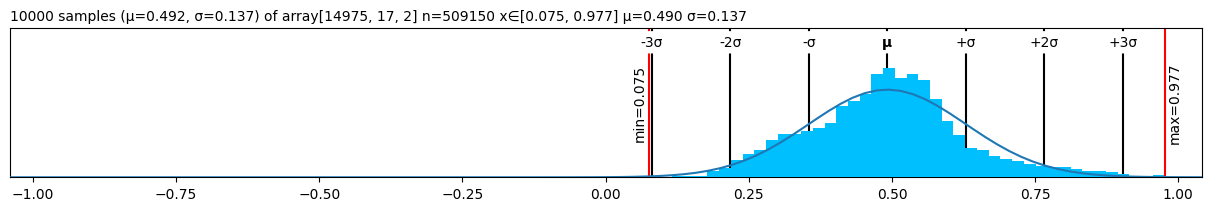

In [31]:
print(lo(X_normalized))
print(lo(y_normalized))
lo(X_normalized).plt

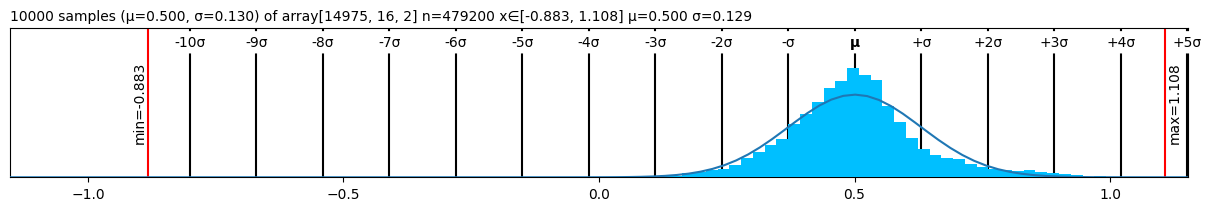

In [23]:
lo(y_normalized).plt


array[14975, 17, 2] n=509150 (3.9Mb) x∈[-0.010, 1.073] μ=0.488 σ=0.165


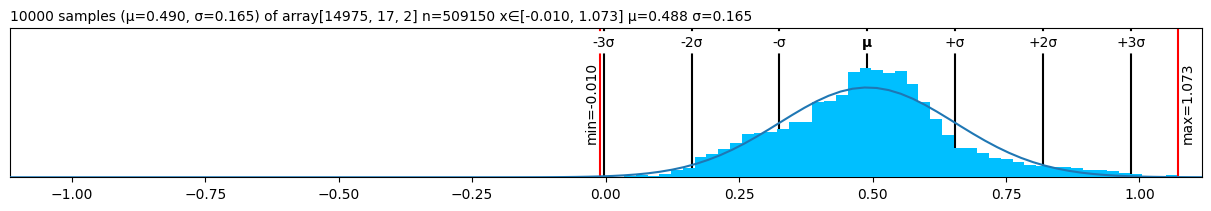

In [32]:
# box_scale = N x 1
# box_center = N x 2
# N x 16 x 2
def normalize1(data):
  # first width & height, but they are the same
  data = copy.deepcopy(data)
  # bbleft point N x 2
  scale_px = 200 * 1.25
  bbox_left = box_center - ((scale_px * box_scale) / 2)[:, np.newaxis]
  bbox_right = box_center + ((scale_px * box_scale) / 2)[:, np.newaxis]

  bbox_width = bbox_right - bbox_left
  data -= bbox_left[:, np.newaxis, :] 
  data /= bbox_width[:, np.newaxis, :]
  return data
  # bbright point
  # return data
X_normalized1 = normalize1(X)
print(lo(X_normalized1))
lo(X_normalized1).plt

array[14975, 16, 2] n=479200 (3.7Mb) x∈[-1.156, 1.233] μ=0.502 σ=0.155


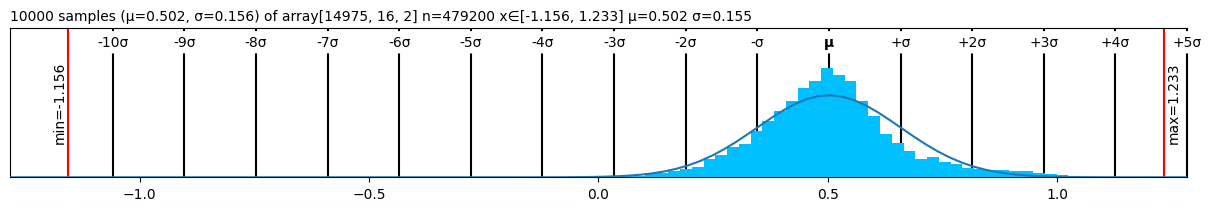

In [33]:
y_normalized1 = normalize1(y)
print(lo(y_normalized1))
lo(y_normalized1).plt

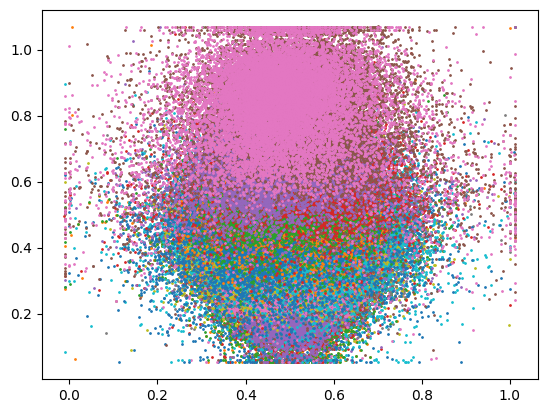

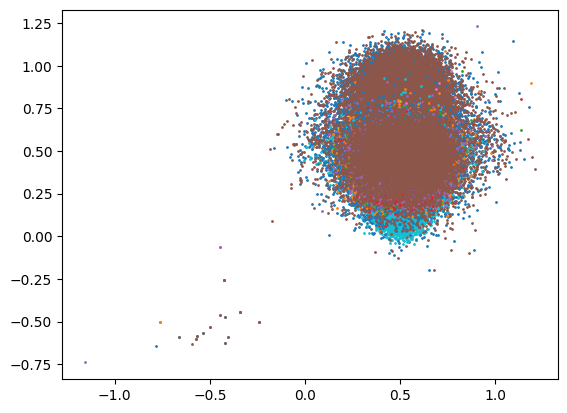

In [26]:
for i in range(17):
  plt.scatter(X_normalized1[:, i, 0],X_normalized1[:, i, 1], s=1)
plt.show()

for i in range(16):
  plt.scatter(y_normalized1[:, i, 0],y_normalized1[:, i, 1], s=1)
plt.show()

## Figure out bounding box

In [11]:
import cv2
from IPython.display import Image, display
from info import MPII_INFO
dataset_info = MPII_INFO()

20152 035355328.jpg
[178.0, 759.0]
6.930725
[[-1.0, -1.0], [-1.0, -1.0], [113.0, 1007.0], [239.0, 1023.0], [-1.0, -1.0], [-1.0, -1.0], [176.0, 1015.0], [255.0, 568.0], [258.978, 484.88], [270.022, 254.12], [88.0, 948.0], [85.0, 797.0], [138.0, 564.0], [371.0, 572.0], [346.0, 844.0], [175.0, 1004.0]]
bbleft: (-688, -107)
bbright: (1044, 1625)


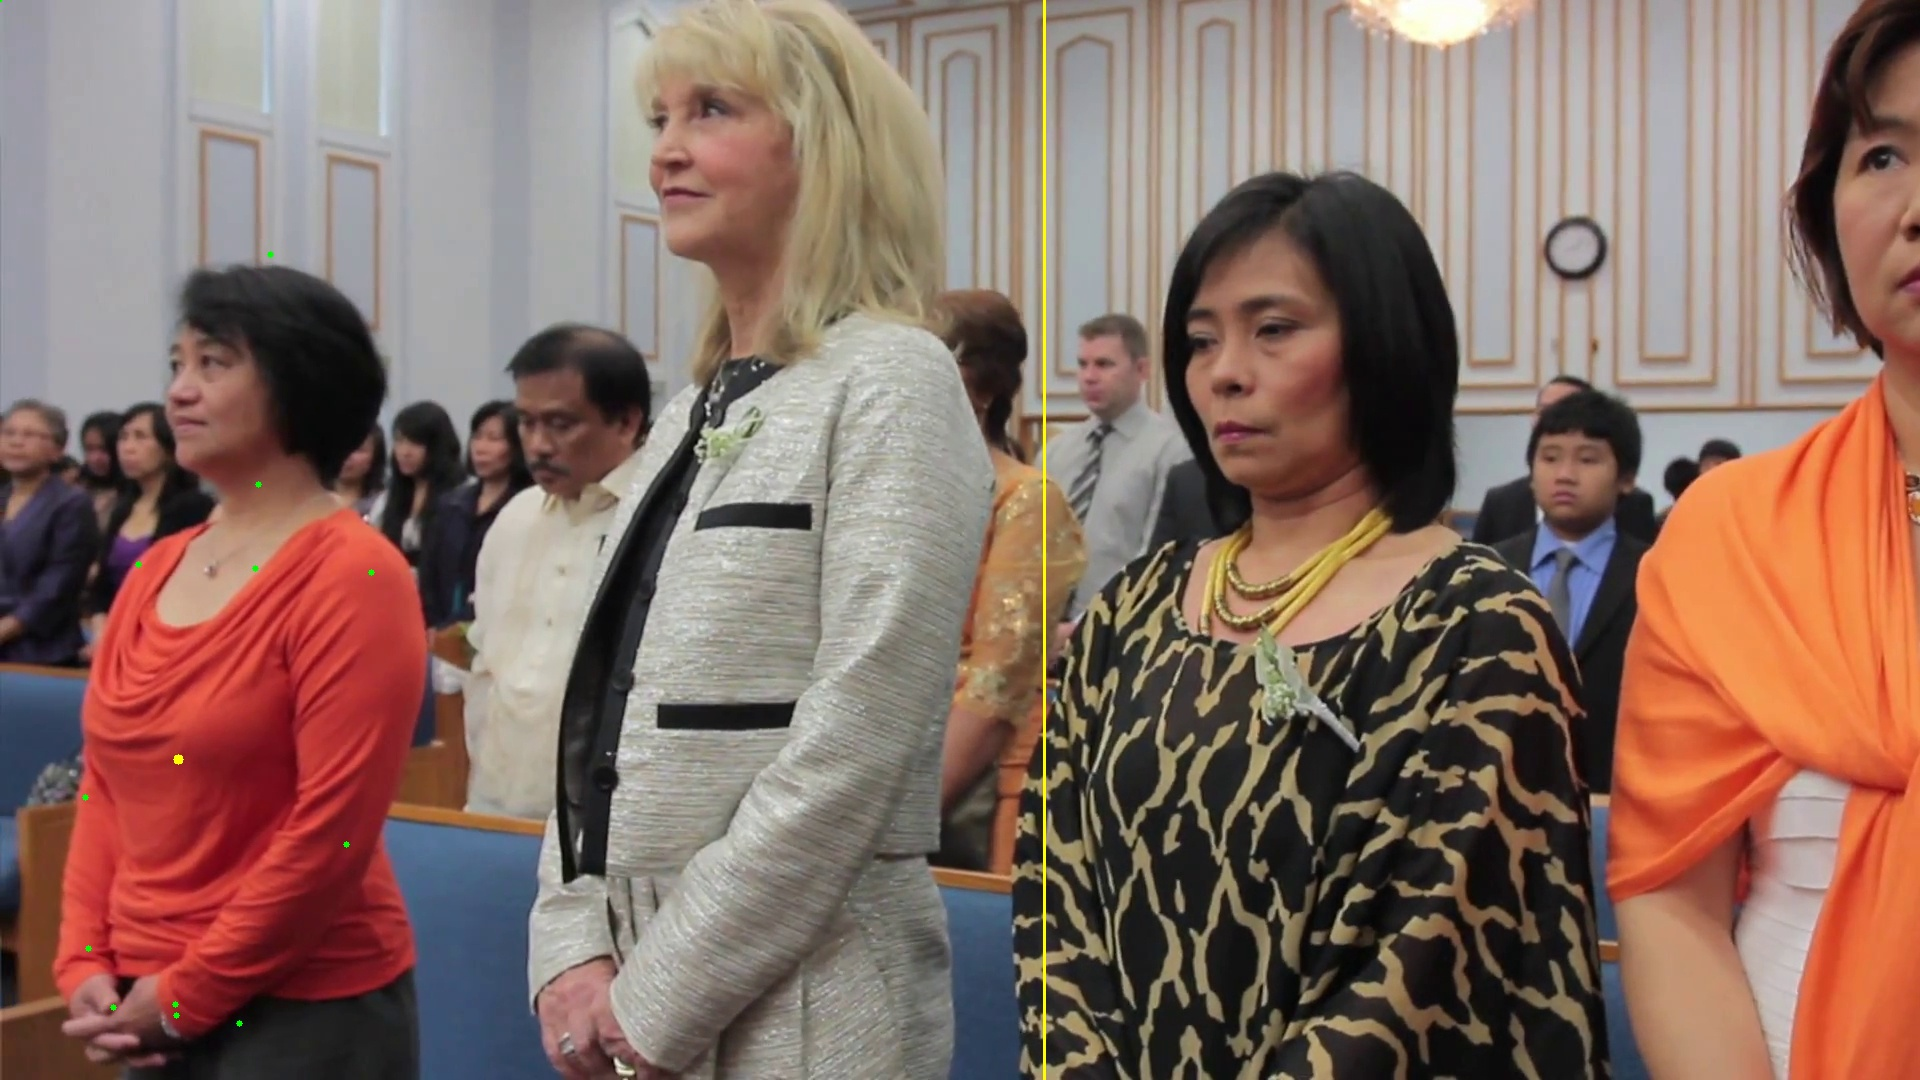

16271 086883347.jpg
[608.0, 690.0]
4.662305
[[725.0, 1023.0], [749.0, 819.0], [487.0, 848.0], [516.0, 792.0], [730.0, 725.0], [845.0, 908.0], [502.0, 820.0], [438.0, 575.0], [442.268, 521.9548], [454.732, 367.0452], [564.0, 696.0], [468.0, 759.0], [408.0, 588.0], [468.0, 561.0], [523.0, 679.0], [571.0, 730.0]]
bbleft: (25, 107)
bbright: (1190, 1272)


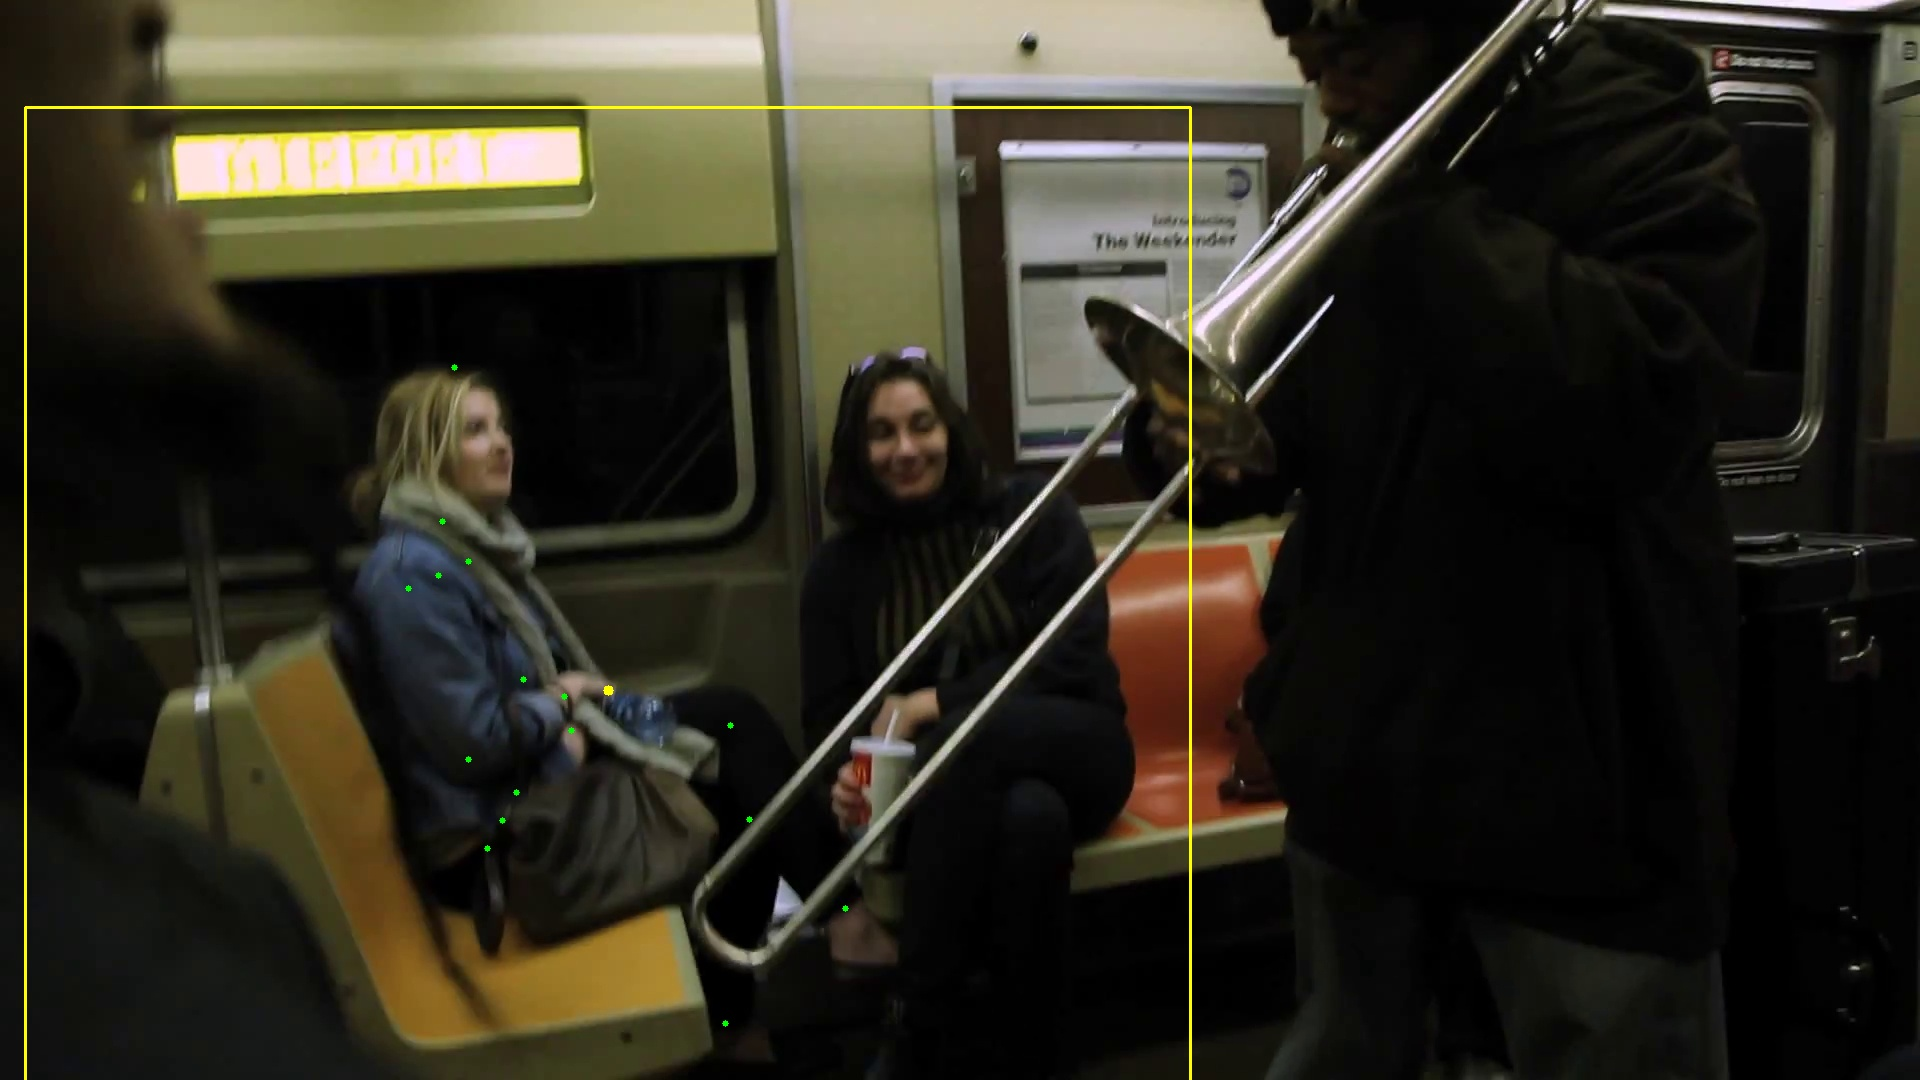

19112 050675782.jpg
[385.0, 195.0]
2.704343
[[336.0, 317.0], [328.0, 220.0], [399.0, 214.0], [445.0, 219.0], [476.0, 259.0], [437.0, 271.0], [422.0, 217.0], [415.0, 134.0], [415.6105, 147.0229], [411.3895, 56.9771], [356.0, 224.0], [327.0, 187.0], [365.0, 136.0], [465.0, 131.0], [477.0, 209.0], [431.0, 241.0]]
bbleft: (46, -143)
bbright: (723, 533)


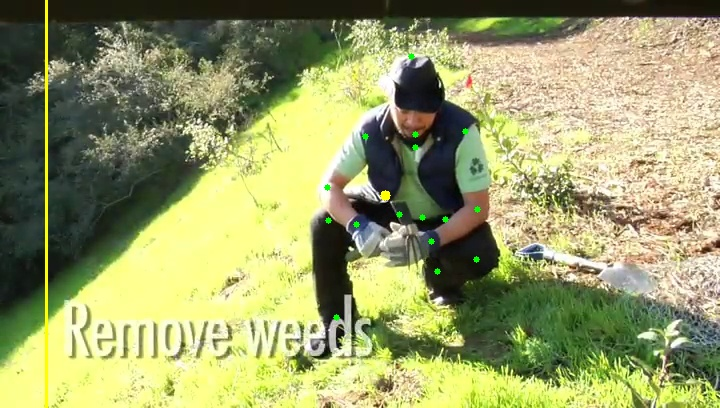

21082 025367615.jpg
[935.0, 356.0]
2.691854
[[950.0, 658.0], [929.0, 525.0], [913.0, 389.0], [947.0, 384.0], [905.0, 529.0], [941.0, 691.0], [930.0, 387.0], [940.0, 179.0], [927.0825, 157.4708], [880.9175, 80.5292], [886.0, 317.0], [941.0, 259.0], [926.0, 185.0], [954.0, 173.0], [875.0, 184.0], [800.0, 165.0]]
bbleft: (598, 19)
bbright: (1271, 692)


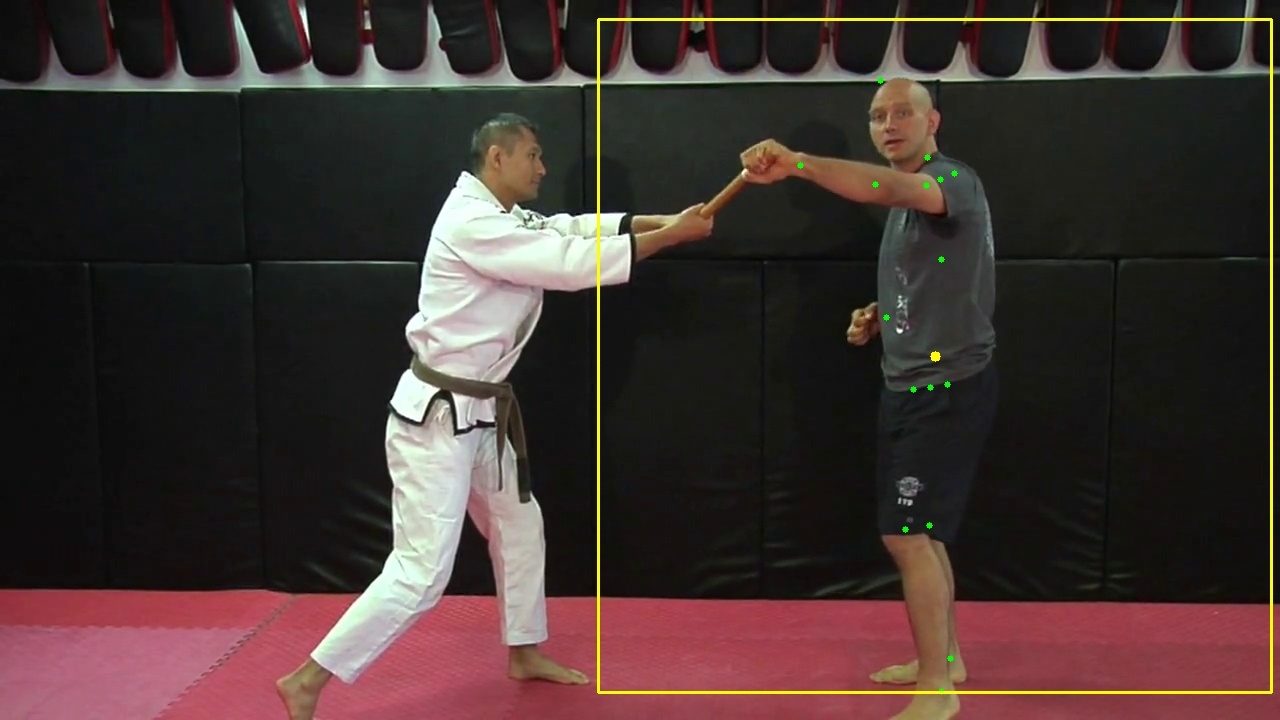

In [15]:

ROOT_FOLDER = "/datagrid/personal/baljibil"
# ground truth
with open(ROOT_FOLDER + '/data/MPII_COCO/annotations/mpii_train.json', 'r') as f:
    annot_truth = json.load(f)
# prediction
with open(ROOT_FOLDER + '/repos/scripts/data/coco_pred_mpii.json', 'r') as f:
    annot_pred_coco = json.load(f)


NUM_IMAGES = 4

# choose image from ground truth
def choose_n_images(gt_json, num_images=10):
  random_numbers = np.random.randint(0, len(gt_json), size=num_images)
  images = list()
  for nums in random_numbers:
     images.append((nums,gt_json[nums]['image']))
  return images

for index, im_path in choose_n_images(annot_truth, NUM_IMAGES):
  print(index, im_path)
  # Load the image
  image = cv2.imread(ROOT_FOLDER + '/data/MPII_COCO/images/' + im_path)

  # Load annotation keypoints from JSON files

  keypoints1 = annot_truth[index]['joints']
  # pred
  print(annot_truth[index]['center'])
  print(annot_truth[index]['scale'])
  center = annot_truth[index]['center']
  scale = annot_truth[index]['scale']
  print(keypoints1)

  for kp in keypoints1:
      x, y = int(kp[0]), int(kp[1])
      cv2.circle(image, (x, y), 3, (0, 255, 0), -1)

  x_bounding_center, y_bounding_center = int(annot_truth[index]['center'][0]), int(annot_truth[index]['center'][1])
  cv2.circle(image, (x_bounding_center, y_bounding_center), 5, (0, 255, 255), -2 )

  scale_px = 200 * 1.25
  bbox_left = (int(center[0] - (scale_px * scale) / 2), int(center[1] - (scale_px * scale) / 2))
  bbox_right = (int(center[0] + (scale_px * scale) / 2), int(center[1] + (scale_px * scale) / 2))
  print("bbleft:", bbox_left)
  print("bbright:", bbox_right)
  cv2.rectangle(image, bbox_left, bbox_right, (0,255,255), 2)
  # Split the image horizontally
#   image1 = image[:, :image.shape[1]//2]
#   image2 = image[:, image.shape[1]//2:]

  # Display the annotated images side by side
  cv2.imwrite(f'tm_results1/image{index}.jpg', image)

  display(Image(filename=f'tm_results1/image{index}.jpg'))


In [13]:
import scipy.io
dic = {}
mat = scipy.io.loadmat('/datagrid/personal/baljibil/data/MPII_COCO/annotations/official/mpii_human_pose_v1_u12_1.mat', dic)
# headboxes = np.array(mat['headboxes_src'])

In [14]:
ann_list = []
img_list = []

head_rect_list = []
for _, (anno, train_flag) in enumerate(  # all images
  zip(mat['RELEASE']['annolist'][0, 0][0], mat['RELEASE']['img_train'][0, 0][0])):

  img_fn = anno['image']['name'][0, 0][0]
  img_list.append(img_fn)

  head_rect = []
  if 'x1' in str(anno['annorect'].dtype):
      head_rect = [
          [x1[0, 0] for x1 in anno['annorect']['x1'][0]], [y1[0, 0] for y1 in anno['annorect']['y1'][0]],
          [x2[0, 0] for x2 in anno['annorect']['x2'][0]], [y2[0, 0] for y2 in anno['annorect']['y2'][0]]
      ]
  else:
      head_rect = []  # TODO
  head_rect_list.append(head_rect)
print(img_list[:10])
print(head_rect_list[:10])




['037454012.jpg', '095071431.jpg', '073199394.jpg', '059865848.jpg', '015601864.jpg', '015599452.jpg', '005808361.jpg', '086617615.jpg', '060111501.jpg', '070807258.jpg']
[[], [], [], [], [[627, 841], [100, 145], [706, 902], [198, 228]], [[607, 903, 27], [70, 73, 36], [752, 1070, 186], [255, 263, 214]], [[914, 427], [79, 66], [1031, 549], [237, 221]], [[252, 510], [187, 265], [331, 580], [266, 343]], [[806], [56], [901], [183]], [[609, 652], [259, 301], [674, 716], [335, 364]]]
